In [3]:
# env: esm1
import torch
# import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model.eval().to(device)

Using device: cuda


### 500 generated seq similarity check

In [ ]:
# Replace with your actual file path
fasta_file = "../model_implementation/peptides_25mers-500.fasta"

# Read sequences into a list
sequences_5000 = [str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")]
# 
    
    
tb_amps = pd.read_csv('../data/all_seq702.csv')

In [33]:
tb_amps['AMP'].dropna().unique()

array([1., 0.])

In [34]:
from Bio import pairwise2
from Bio.Seq import Seq

matched = 0
for gen_seq in sequences_5000:
    for known in tb_amps['Sequences'].dropna().unique():
        score = pairwise2.align.globalxx(Seq(gen_seq), Seq(known), score_only=True)
        if score / len(gen_seq) > 0.80:  # Adjust threshold as needed
            print(f"Match: {gen_seq} ≈ {known} | Score: {score} | {score / len(gen_seq)}")
            matched += 1
            
print(f"Total matched sequences: {matched} out of {len(sequences_5000)}")
print(f"Match percentage: {matched / len(sequences_5000) * 100}%")

Match: QWQHGAHYHSSSAAKHHGCYHPPPR ≈ KPKGMTSSQWFKIQHMQPSPQACNSAMKNINKHTKRCKDLNTFLHEPFSSVAATCQTPKIACKNGDKNCHQSHGAVSLTMCKLTSGKYPNCRYKEKRQNKSYVVACKPPQKKDSQQFHLVPVHLDRVL | Score: 21.0 | 0.84
Match: QYAKGGPRDHYTPPYSSGAPHGKPP ≈ QNERYEKFLRQHYDAKPNGRDDRYCESMMKERKLTSPCKDVNTFIHGTKKNIRAICGKKGSPYGENFRISNSPFQITTCTHSGASPRPPCGYRAFKDFRYIVIACEDGWPVHFDESFISP | Score: 21.0 | 0.84
Match: CRIRRPPPPPPPRPPRPPPPPPDPP ≈ RRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFP | Score: 21.0 | 0.84
Match: SKSSSPPSAVHHKGPGDPPKPGRPK ≈ MSESSSKSSQPLASKQEKDGTEKRGRGRPRKQPPVSPGTALVGSQKEPSEVPTPKRPRGRPKGSKNKGAAKTRKTTTTPGRKPRGRPKKLEKEEEEGISQESSEEEQ | Score: 21.0 | 0.84
Total matched sequences: 4 out of 500
Match percentage: 0.8%


## presence of AMP

In [ ]:
from Bio import SeqIO

def read_fasta_sequences(fasta_path):
    """
    Reads sequences from a FASTA file and returns them as a list of strings.

    Args:
        fasta_path (str): Path to the FASTA file.

    Returns:
        List[str]: A list of amino acid or nucleotide sequences as strings.
    """
    sequences = [str(record.seq) for record in SeqIO.parse(fasta_path, "fasta")]
    return sequences
# generated = read_fasta_sequences("1745419634972_AMPCandidates-pos-nontox.fa") # transfer learning outputs
generated = read_fasta_sequences('../generated/amp-scanner-results_CSM-nontox.fa')
# generated = read_fasta_sequences("1745429455143_AMPCandidates-pos-nontox.fa") # no transfer learning outputs
print(len(generated))

93


DRAMP

In [41]:
dramps = pd.read_csv("./database_check/dramps_general_amps.txt", sep = '\t')
dramps['Sequence']

0                           SLGPAIKATRQVCPKATRFVTVSCKKSDCQ
1                                 VTSWSLCTPGCTSPGGGSNCSFCC
2                                 GNGVLKTISHECNMNTWQFLFTCC
3                                    SSSGWLCTLTIECGTIICACR
4        MSWLNFLKYIAKYGKKAVSAAWKYKGKVLEWLNVGPTLEWVWQKLK...
                               ...                        
11607                                          LLLLLLLLLLL
11608                              LLLLLLLLLLLLLLLLLLLLLLL
11609                LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
11610                LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
11611                                   GAGIVVASIDTGVRVSHE
Name: Sequence, Length: 11612, dtype: object

In [42]:
# Create a set of sequences from dramps for faster lookup
dramps_set = set(dramps['Sequence'])

# Filter out sequences in generated that are present in dramps_set
generated = [seq for seq in generated if seq not in dramps_set]

print(f"Remaining sequences in 'generated': {len(generated)}")

Remaining sequences in 'generated': 93


APS

In [43]:
aps = read_fasta_sequences("./database_check/aps.fasta")


In [44]:
aps_set = set(aps)

generated = [seq for seq in generated if seq not in aps_set]

print(f"Remaining sequences in 'generated': {len(generated)}")

Remaining sequences in 'generated': 93


DBBASP

In [45]:
dbbasp = pd.read_csv("./database_check/DBAASP_peptides.csv")
dbbasp['SEQUENCE']

0        NLVSGLIEARKYLEQLHRKLKNCKV    ENREVPPGFTALIKTLR...
1                    WLNALLHHGLNCAKGVLA    ALLHHGLNCAKGVLA
2                   KWLNALLHHGLNCAKGVLA    ALLHHGLNCAKGVLA
3        SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG    IA...
4        XTCASRCPRPCNAGLCCSIYGYCGSGNAYCGAGNCRCQCRG    X...
                               ...                        
23358                                                  Rxr
23359                                                  RxR
23360                                                  rXr
23361                                                  RXr
23362                                                  rxR
Name: SEQUENCE, Length: 23363, dtype: object

In [46]:
aps_set = set(dbbasp['SEQUENCE'])

generated = [seq for seq in generated if seq not in aps_set]

print(f"Remaining sequences in 'generated': {len(generated)}")

Remaining sequences in 'generated': 93


Uniprot

In [47]:
import requests

def check_uniprot(peptide):
    url = f"https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f"sequence:{peptide}",
        "format": "json",
        "fields": "accession,id,sequence"
    }
    response = requests.get(url, params=params)
    results = response.json()
    return results.get("results", [])

# Example usage
peptides = generated
for pep in peptides:
    hits = check_uniprot(pep)
    print(f"{pep}: {'✅ Found' if hits else '❌ Not found'}")


EYPPGGGYPPGYYGGG: ❌ Not found
KAAYYYHGPKGKGYHPHPPG: ❌ Not found
IQYYPYGGGHKHYIHPGYGYRGDYPPRGKGYPHGHHPPY: ❌ Not found
IAPRPRKLKGGGPHLYHKR: ❌ Not found
FAGGYYPYYGYP: ❌ Not found
EVHGGKYYDLKGGHYHPPKYYHKHHG: ❌ Not found
VHAHYHGKYHPRHPKPPPGY: ❌ Not found
DAAPPGKGPGPKYG: ❌ Not found
WAYYHPYPNHGYYP: ❌ Not found
QEPYYRPGGYPFGP: ❌ Not found
CAKPPGPHHR: ❌ Not found
ASPLGIHHYKYPYKPKGPHG: ❌ Not found
DAYYYKGYKYYYHKYHGPYP: ❌ Not found
HANYGLYQPPHHYYYYLKYP: ❌ Not found
IRYHKGPGKPHPGGYKGPRG: ❌ Not found
TAAKLPPYLHYHKGGYYPKG: ❌ Not found
YAKPPHYPPPKH: ❌ Not found
APAGGGYPKGKKGKK: ❌ Not found
VLAHPKYPGGPGPYPKPKPY: ❌ Not found
VLVPSHGRYYKKRHYYKRRG: ❌ Not found
QHSHYKFYGHYYPPKHHPRYWGKGPKYHGGRPGG: ❌ Not found
IASPGGYKKYYYRKGRPKYG: ❌ Not found
RAKGGGPRPYKHYGYGYGYP: ❌ Not found
WAKYKPPKPPYGHYYKPHGKHPGYYPPHYPGYYYPPKYYG: ❌ Not found
KGSYGPKYYY: ❌ Not found
AGGFYYYYPRYYHKGYPHP: ❌ Not found
GFEPLRLYPPYKGGRPPGGG: ❌ Not found
MGYKHPHGGGGGP: ❌ Not found
KFYKPGGGGHGG: ❌ Not found
FGGHKPGYPGY: ❌ Not found
HAGSRGGKKP

### scanner outputs

In [ ]:
# scanner = pd.read_csv("./1745419634972_results/1745419634972_Prediction_Summary.csv")
scanner = pd.read_csv("../generated/amp-scanner-v2_results/1746183770602_AMPCandidates.fa")


In [8]:
scanner.loc[scanner['Prediction_Class'] == 'AMP', :]
scanner.sort_values(by="Prediction_Probability", ascending=False)

,SeqID,Prediction_Class,Prediction_Probability,Sequence
3,peptide3,AMP,1.0000,IHWTKYGGGHKHKKHKGKGYKGDKKKKGKGPKKGKKKKP
33,peptide33,AMP,1.0000,HAAPPGGKKKKKKGHKPKKGKKHHKGKHKGPKKKK
25,peptide25,AMP,1.0000,WAGYKKKKKKPGHYPKKHGKKKGYYKKIKKGPKYKKKYPG
37,peptide37,AMP,1.0000,PAAPKPGPGGGKKKKPKKKKKHKKHPKKPKGYKKGK
74,peptide74,AMP,1.0000,VAYKSKKKKGGHKGKYGKKPGKKYKKKPKGVKKHKKKG
...,...,...,...,...
1,peptide1,Non-AMP,0.0755,AAADKGHKKKGKKG
65,peptide65,Non-AMP,0.0684,NAALRPDKGHYGKKKKDKKG
50,peptide50,Non-AMP,0.0670,LATAKHKKPGDGP
94,peptide94,Non-AMP,0.0172,SHIAEFKKHDGYHKK


In [12]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Filter sequences with length > 10 from the dbbasp DataFrame
filtered_df = dbbasp[dbbasp['SEQUENCE'].str.len() > 10]

# Randomly select 500 sequences (set random_state for reproducibility)
sample_df = filtered_df.sample(n=500, random_state=42)

# Create SeqRecord objects for each sequence
records = [SeqRecord(Seq(seq), id=f"seq{i}", description="") 
           for i, seq in enumerate(sample_df['SEQUENCE'])]

# Save to a FASTA file
SeqIO.write(records, "dbbasp_selected_sequences.fasta", "fasta")

500

In [16]:
ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df  = ref_df [
    (ref_df ['Sequences'].str.len() >= 10) &
    (ref_df ['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~ref_df ['Sequences'].str.contains('X'))
]
ref_df = ref_df[(ref_df['AMP'] == 1)]

In [23]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

records = [SeqRecord(Seq(seq), id=f"{label}_{i}", description="") 
           for i, seq in enumerate(ref_df['Sequences'].tolist())]
SeqIO.write(records, "tb-amp205.fasta", "fasta")


205

# physical property filtering

In [ ]:
from Bio import SeqIO
from modlamp.descriptors import GlobalDescriptor, PeptideDescriptor
from modlamp.analysis import GlobalAnalysis
import pandas as pd
import re

# Load sequences from FASTA

fasta_path = "../generated/amp-scanner-results_CSM-nontox.fa"
records = list(SeqIO.parse(fasta_path, "fasta"))

# Prepare storage
data = {
    "ID": [],
    "Sequence": [],
    "Length": [],
    "Net_Charge": [],
    # "Hydrophobicity": [],
    "Isoelectric_Point": [],
    "Hydrophobic_Moment": [],
    # "Instability_Index": [],
    "Boman_Index": [],
    # "GRAVY": []
}

# Valid amino acids for modlamp
valid_aa_pattern = re.compile("^[ACDEFGHIKLMNPQRSTVWY]+$")

for record in records:
    seq = str(record.seq).upper()
    
    if not valid_aa_pattern.match(seq):
        continue  # Skip non-standard sequences
    
    gd = GlobalDescriptor([seq])
    glo = GlobalAnalysis([seq]) 
    pd_ = PeptideDescriptor(seq, 'eisenberg')

    gd.instability_index()
    
    data["ID"].append(record.id)
    
    data["Sequence"].append(seq)
    
    data["Length"].append(len(seq))
    
    gd.calculate_charge(ph=7.4, amide=True)
    data["Net_Charge"].append(gd.descriptor[0][0])
    
    # # pd_.calculate_profile(prof_type='H')
    # glo.calc_H()
    # print(glo.descriptor)
    # data["Hydrophobicity"].append(glo.descriptor[0][0])
    
    pd_.calculate_moment(window=1000, angle=100, modality="mean")
    data["Hydrophobic_Moment"].append(pd_.descriptor[0][0])
    
    # gd.instability_index()
    # print(gd.descriptor)
    # data["Instability_Index"].append(gd.descriptor[0][0])
    
    gd.boman_index()
    data["Boman_Index"].append(gd.descriptor[0][0])
    
    gd.isoelectric_point(amide=True)
    data["Isoelectric_Point"].append(gd.descriptor[0][0])
    
    # gd.calculate_gravy()
    # data["GRAVY"].append(gd.descriptor[0][0])

# Create DataFrame
df = pd.DataFrame(data)
# df.to_csv("AMP_Features_modlamp.csv", index=False)
# print(df.head())

filtered_df = df[
    (df["Net_Charge"] >= 2) &  # 1. Charge is most essential for membrane targeting
    (df["Hydrophobic_Moment"] > 0.3)  & # 2. Amphipathicity — key to membrane disruption
    # (df["Hydrophobicity"].between(0.2, 0.6)) &  # 3. Balanced polarity for interaction
    # (df["Length"].between(8, 60)) &  # 4. Length affects structure/stability
    (df["Isoelectric_Point"] > 7.5) &  # 5. Related to net charge and solubility
    (df["Boman_Index"] < 10.5)  # 6. Lower = less nonspecific binding
    # (df["GRAVY"].between(-1.5, 10)) &  # 7. Broader window for potential activity
    # (df["Instability_Index"] < 40)  # 8. Least critical; relates to proteolytic stability
]

filtered_df
# df

,ID,Sequence,Length,Net_Charge,Isoelectric_Point,Hydrophobic_Moment,Boman_Index
10,peptide11,CAKPPGPHHR,10,2.919,11.400391,0.352883,2.576000
14,peptide15,IRYHKGPGKPHPGGYKGPRG,20,6.068,11.541016,0.329718,2.276500
35,peptide38,EIYRGHHRGPRYHYGYGKYG,20,4.105,10.215088,0.497958,3.109000
40,peptide43,CAAKPGRKLKKP,12,5.834,11.751953,0.613583,2.196667
41,peptide44,RAVYKHPKGGPP,12,4.028,11.606445,0.508348,1.924167
54,peptide59,DFGPKGGPGYKKPYHPP,17,3.026,10.294189,0.342704,1.386471
68,peptide73,GAKYGGKYHKGGY,13,4.024,10.412354,0.403633,1.170769
71,peptide77,RKPPKKYLKG,10,5.985,11.770020,0.601833,3.140000
91,peptide97,FPKYPRPGPYYG,12,2.983,10.280273,0.462052,1.335833


# blastp

In [ ]:
blastp \
       -query "../generated/amp-scanner-results_CSM-nontox.fa\
       -db tb_amps_db \
       -evalue 1000 \
       -task blastp-short \
       -outfmt 6 \
       -out blastp_results060525.tsv

In [67]:
blast_df = pd.read_csv("blastp_results060525.tsv", sep = '\t', header = None)

import pandas as pd
import numpy as np


# Define column names based on outfmt 6
blast_df.columns = [
    "query_id", "subject_id", "%identity", "alignment_length", "mismatches", "gap_opens",
    "q_start", "q_end", "s_start", "s_end", "evalue", "bit_score"
]

E_VALUE_CUTOFF = 1e-1

filtered = blast_df[
    (blast_df["evalue"] <= E_VALUE_CUTOFF)
]
filtered

,query_id,subject_id,%identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score
270,peptide66,TB-AMP_196,83.333,6,1,0,4,9,59,64,0.08,18.0


In [68]:
print(filtered['%identity'].min(), filtered['%identity'].max())
print(filtered['alignment_length'].min(), filtered['alignment_length'].max())

83.333 83.333
6 6


In [ ]:
blast_df['%identity']

,query_id,subject_id,%identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score
0,peptide0,TB-AMP_187,50.000,10,5,0,7,16,24,33,54.0,10.4
1,peptide0,TB-AMP_73,100.000,3,0,0,14,16,13,15,535.0,7.4
2,peptide2,TB-AMP_181,30.000,20,14,0,1,20,17,36,19.0,12.1
3,peptide2,TB-AMP_194,41.667,12,7,0,1,12,17,28,29.0,11.2
4,peptide2,TB-AMP_182,36.842,19,9,1,2,20,20,35,139.0,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...
379,peptide96,TB-AMP_47,66.667,6,2,0,2,7,5,10,235.0,8.7
380,peptide96,TB-AMP_47,57.143,7,3,0,2,8,19,25,905.0,7.0
381,peptide97,TB-AMP_11,66.667,6,2,0,4,9,21,26,26.0,10.8
382,peptide98,TB-AMP_197,100.000,4,0,0,5,8,86,89,0.4,15.9


In [ ]:

# Define filtering criteria
MIN_IDENTITY = 60
MIN_LENGTH = 6

# Filter hits by biological relevance
filtered = blast_df[
    (blast_df["%identity"] >= MIN_IDENTITY) &
    (blast_df["alignment_length"] >= MIN_LENGTH) &
    (blast_df["evalue"] <= E_VALUE_CUTOFF)
]

# Group by query peptide
summary = (
    filtered.groupby("query_id")
    .agg(
        max_identity=("%identity", "max"),
        mean_identity=("%identity", "mean"),
        best_bit_score=("bit_score", "max"),
        best_evalue=("evalue", "min"),
    )
    .reset_index()
)

# Add binary flag
summary["has_similarity"] = 1

# Identify peptides with no valid hits
all_queries = pd.Series(blast_df["query_id"].unique(), name="query_id")
summary = all_queries.to_frame().merge(summary, on="query_id", how="left")

# Fill NaNs for queries with no valid hits
summary["has_similarity"] = summary["has_similarity"].fillna(0).astype(int)
summary["max_identity"] = summary["max_identity"].fillna(0)
summary["mean_identity"] = summary["mean_identity"].fillna(0)
summary["best_bit_score"] = summary["best_bit_score"].fillna(0)
summary["best_evalue"] = summary["best_evalue"].fillna(np.nan)

# Save summary
summary.to_csv("blast_summary.csv", index=False)
print("✅ Summary saved to blast_summary.csv")


✅ Summary saved to blast_summary.csv


In [53]:
summary

,query_id,max_identity,mean_identity,best_bit_score,best_evalue,has_similarity
0,peptide0,0.000,0.000000,0.0,NaN,0
1,peptide2,0.000,0.000000,0.0,NaN,0
2,peptide3,62.500,61.666667,15.5,2.5,1
3,peptide4,66.667,66.667000,7.0,768.0,1
4,peptide6,75.000,72.222333,12.1,21.0,1
...,...,...,...,...,...,...
69,peptide94,0.000,0.000000,0.0,NaN,0
70,peptide96,83.333,71.212000,12.5,13.0,1
71,peptide97,66.667,66.667000,10.8,26.0,1
72,peptide98,0.000,0.000000,0.0,NaN,0


# entropy comparison

In [21]:
gen_amp_filtered = ['CAKPPGPHHR',
'IRYHKGPGKPHPGGYKGPRG',
'EIYRGHHRGPRYHYGYGKYG',
'CAAKPGRKLKKP',
'RAVYKHPKGGPP',	
'DFGPKGGPGYKKPYHPP',
'GAKYGGKYHKGGY',
'RKPPKKYLKG',
'FPKYPRPGPYYG']

ref_df = pd.read_csv("../data/all_seq702.csv").drop_duplicates(subset='Sequences')
ref_df = ref_df[(ref_df['AMP'] == 1) & (ref_df['Sequences'].str.len().between(10, 40))]
reference_sequences = ref_df["Sequences"].tolist()

adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_sequences = adam_df['Sequences'].str[:220].tolist()
adam_sequences = [x for x in adam_sequences if x not in reference_sequences]

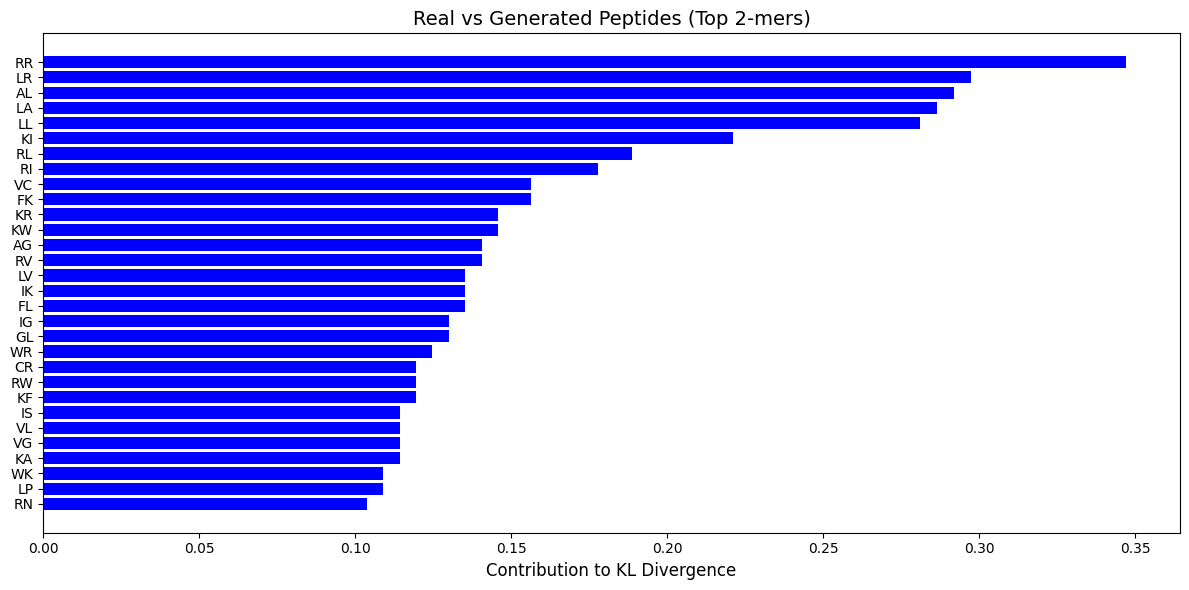

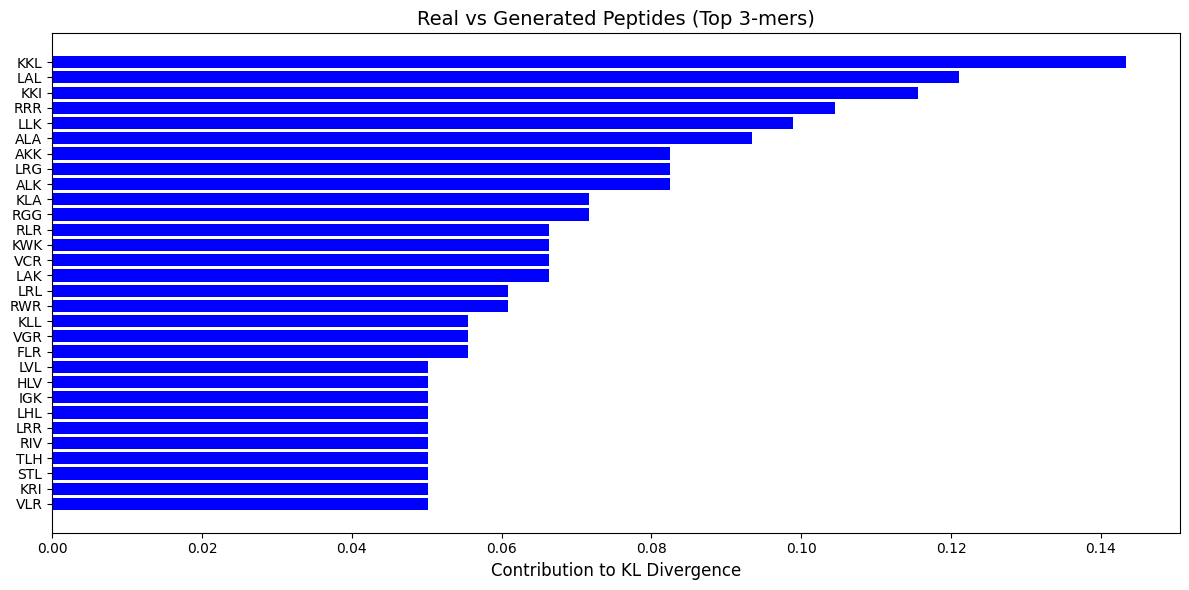

In [22]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def get_kmer_freqs(seqs, k=2):
    kmer_counts = Counter()
    total = 0
    for seq in seqs:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            kmer_counts[kmer] += 1
            total += 1
    return {k: v / total for k, v in kmer_counts.items()}

def kl_divergence(p, q):
    eps = 1e-10  # small value to avoid log(0)
    all_keys = set(p.keys()) | set(q.keys())
    divergence = {}
    for k in all_keys:
        p_val = p.get(k, eps)
        q_val = q.get(k, eps)
        divergence[k] = p_val * np.log(p_val / q_val)
    return divergence

def plot_word_shift(p_freqs, q_freqs, k=2, title="Word Shift Plot", top_n=30):
    divergence = kl_divergence(p_freqs, q_freqs)
    # Sort by absolute contribution
    sorted_div = sorted(divergence.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]

    labels, values = zip(*sorted_div)
    colors = ['blue' if v > 0 else 'orange' for v in values]  # blue = real > gen, orange = gen > real

    fig, ax = plt.subplots(figsize=(12, 6))
    y_pos = np.arange(len(labels))
    ax.barh(y_pos, values, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('Contribution to KL Divergence', fontsize=12)
    ax.set_title(title + f" (Top {k}-mers)", fontsize=14)
    plt.tight_layout()
    plt.show()

# Example sequences
filtered_9 = gen_amp_filtered
tb_real_amps = reference_sequences

# Run analysis for k=2 and k=3
for k in [2, 3]:
    gen_freqs = get_kmer_freqs(filtered_9, k=k)
    real_freqs = get_kmer_freqs(tb_real_amps, k=k)
    plot_word_shift(real_freqs, gen_freqs, k=k, title="Real vs Generated Peptides")


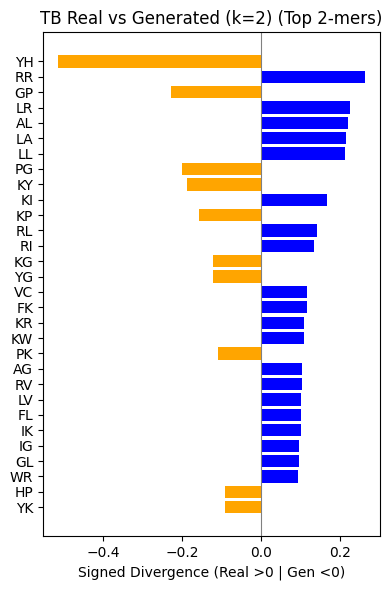

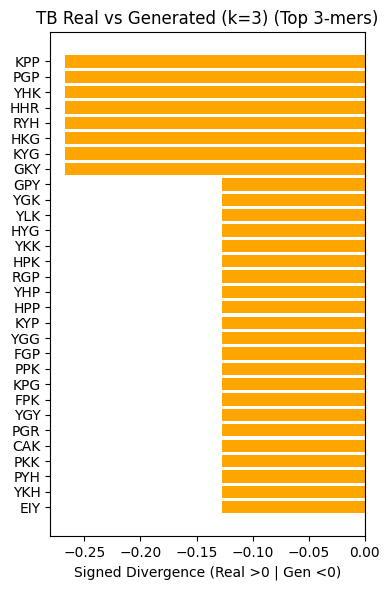

In [28]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def get_kmer_freqs(seqs, k=2, epsilon=1e-8):
    kmer_counts = Counter()
    for seq in seqs:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            kmer_counts[kmer] += 1

    # Normalize with smoothing
    total = sum(kmer_counts.values()) + epsilon * len(kmer_counts)
    return {k: (v + epsilon) / total for k, v in kmer_counts.items()}

def get_all_kmers(seqs1, seqs2, k=2):
    all_kmers = set()
    for seqs in [seqs1, seqs2]:
        for seq in seqs:
            for i in range(len(seq) - k + 1):
                all_kmers.add(seq[i:i+k])
    return all_kmers

def compute_signed_divergence(p_freqs, q_freqs, all_kmers):
    divergence = {}
    for kmer in all_kmers:
        p = p_freqs.get(kmer, 1e-8)
        q = q_freqs.get(kmer, 1e-8)
        # Signed KL-like divergence component
        divergence[kmer] = p * np.log(p / q) - q * np.log(q / p)
    return divergence

def plot_word_shift(p_seqs, q_seqs, k=2, title="Word Shift", top_n=30):
    all_kmers = get_all_kmers(p_seqs, q_seqs, k=k)
    p_freqs = get_kmer_freqs(p_seqs, k)
    q_freqs = get_kmer_freqs(q_seqs, k)

    divergence = compute_signed_divergence(p_freqs, q_freqs, all_kmers)
    top = sorted(divergence.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]

    labels, values = zip(*top)
    colors = ['blue' if v > 0 else 'orange' for v in values]

    plt.figure(figsize=(4, 6))
    y = np.arange(len(labels))
    plt.barh(y, values, color=colors)
    plt.yticks(y, labels, fontsize=10)
    plt.gca().invert_yaxis()
    plt.axvline(0, color='gray', linewidth=0.8)
    plt.xlabel("Signed Divergence (Real >0 | Gen <0)")
    plt.title(f"{title} (Top {k}-mers)")
    plt.tight_layout()
    plt.show()

# Example usage
plot_word_shift(tb_real_amps, filtered_9, k=2, title="TB Real vs Generated (k=2)")
plot_word_shift(tb_real_amps, filtered_9, k=3, title="TB Real vs Generated (k=3)")


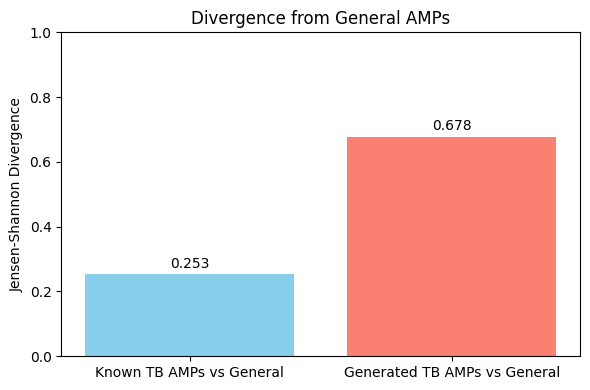

In [10]:
import itertools
import numpy as np
from collections import Counter
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# Define amino acids
aa = 'ACDEFGHIKLMNPQRSTVWY'

# Generate all possible 2-mers
def generate_kmers(k=2):
    return [''.join(p) for p in itertools.product(aa, repeat=k)]

# Compute normalized k-mer frequencies
def compute_kmer_freqs(sequences, k=2):
    kmers = generate_kmers(k)
    counts = Counter()
    total = 0
    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            if all(c in aa for c in kmer):
                counts[kmer] += 1
                total += 1
    # Normalize
    return np.array([counts[k] / total if total > 0 else 0 for k in kmers])

# Dummy input: replace with your sequences
general_amp = adam_sequences # General AMP sequences
tb_known = reference_sequences     # Known TB-specific AMPs
tb_generated = gen_amp_filtered    # Generated TB-specific AMPs

# Compute distributions
dist_general = compute_kmer_freqs(general_amp)
dist_known = compute_kmer_freqs(tb_known)
dist_generated = compute_kmer_freqs(tb_generated)

# Compute Jensen-Shannon Divergence
jsd_known = jensenshannon(dist_known, dist_general)
jsd_generated = jensenshannon(dist_generated, dist_general)

# Bar plot
labels = ['Known TB AMPs vs General', 'Generated TB AMPs vs General']
divergences = [jsd_known, jsd_generated]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, divergences, color=['skyblue', 'salmon'])
plt.ylabel('Jensen-Shannon Divergence')
plt.title('Divergence from General AMPs')
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f'{height:.3f}', ha='center')
plt.tight_layout()
plt.show()


In [ ]:

non_amp = pd.read_csv('../data/uniprotkb_length_10_TO_80_NOT_antimicro_2025_04_14.fasta.csv')
non_amp_ = non_amp['Sequence'].unique()
non_amp_ = non_amp[:200]

['AA', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AK', 'AL', 'AM', 'AN', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AV', 'AW', 'AY', 'CA', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CV', 'CW', 'CY', 'DA', 'DC', 'DD', 'DE', 'DF', 'DG', 'DH', 'DI', 'DK', 'DL', 'DM', 'DN', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DV', 'DW', 'DY', 'EA', 'EC', 'ED', 'EE', 'EF', 'EG', 'EH', 'EI', 'EK', 'EL', 'EM', 'EN', 'EP', 'EQ', 'ER', 'ES', 'ET', 'EV', 'EW', 'EY', 'FA', 'FC', 'FD', 'FE', 'FF', 'FG', 'FH', 'FI', 'FK', 'FL', 'FM', 'FN', 'FP', 'FQ', 'FR', 'FS', 'FT', 'FV', 'FW', 'FY', 'GA', 'GC', 'GD', 'GE', 'GF', 'GG', 'GH', 'GI', 'GK', 'GL', 'GM', 'GN', 'GP', 'GQ', 'GR', 'GS', 'GT', 'GV', 'GW', 'GY', 'HA', 'HC', 'HD', 'HE', 'HF', 'HG', 'HH', 'HI', 'HK', 'HL', 'HM', 'HN', 'HP', 'HQ', 'HR', 'HS', 'HT', 'HV', 'HW', 'HY', 'IA', 'IC', 'ID', 'IE', 'IF', 'IG', 'IH', 'II', 'IK', 'IL', 'IM', 'IN', 'IP', 'IQ', 'IR', 'IS', 'IT', 'IV', 'IW', 'IY', 'KA', 'KC', 'KD', 'KE', 'KF', 'KG', 'KH

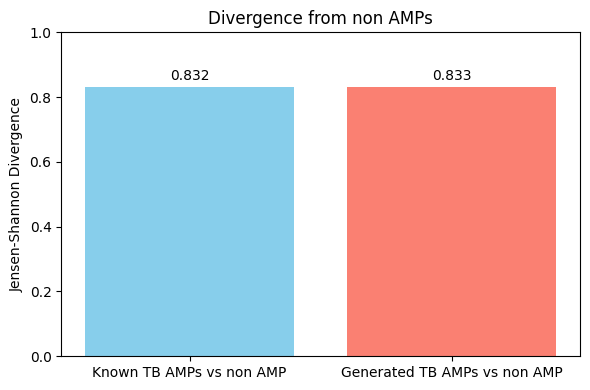

In [ ]:
import itertools
import numpy as np
from collections import Counter
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# Define amino acids
aa = 'ACDEFGHIKLMNPQRSTVWY'

# Generate all possible 2-mers
def generate_kmers(k=2):
    return [''.join(p) for p in itertools.product(aa, repeat=k)]

# Compute normalized k-mer frequencies
def compute_kmer_freqs(sequences, k=2):
    kmers = generate_kmers(k)
    counts = Counter()
    total = 0
    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            if all(c in aa for c in kmer):
                counts[kmer] += 1
                total += 1
    # Normalize
    return np.array([counts[k] / total if total > 0 else 0 for k in kmers])

# Dummy input: replace with your sequences
general_amp = non_amp_ # General AMP sequences
tb_known = reference_sequences     # Known TB-specific AMPs
tb_generated = gen_amp_filtered    # Generated TB-specific AMPs

# Compute distributions
dist_general = compute_kmer_freqs(general_amp)
dist_known = compute_kmer_freqs(tb_known)
dist_generated = compute_kmer_freqs(tb_generated)

# Compute Jensen-Shannon Divergence
jsd_known = jensenshannon(dist_known, dist_general)
jsd_generated = jensenshannon(dist_generated, dist_general)

# Bar plot
labels = ['Known TB AMPs vs non AMP', 'Generated TB AMPs vs non AMP']
divergences = [jsd_known, jsd_generated]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, divergences, color=['skyblue', 'salmon'])
plt.ylabel('Jensen-Shannon Divergence')
plt.title('Divergence from non AMPs')
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f'{height:.3f}', ha='center')
plt.tight_layout()
plt.show()


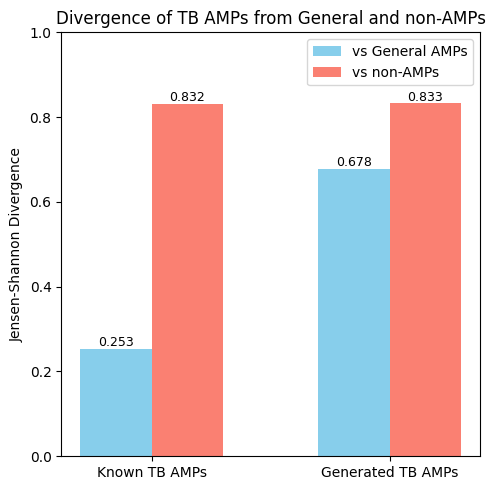

In [38]:
import itertools
import numpy as np
from collections import Counter
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# Define amino acids
aa = 'ACDEFGHIKLMNPQRSTVWY'

# Generate all possible k-mers
def generate_kmers(k=2):
    return [''.join(p) for p in itertools.product(aa, repeat=k)]

# Compute normalized k-mer frequencies
def compute_kmer_freqs(sequences, k=2):
    kmers = generate_kmers(k)
    counts = Counter()
    total = 0
    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            if all(c in aa for c in kmer):
                counts[kmer] += 1
                total += 1
    return np.array([counts[k] / total if total > 0 else 0 for k in kmers])

# Replace with your actual datasets
general_amp = adam_sequences         # General AMP sequences
non_amp = non_amp_                  # Random or non-AMP sequences
tb_known = reference_sequences      # Known TB-specific AMPs
tb_generated = gen_amp_filtered     # Generated TB-specific AMPs

# Compute distributions
dist_general = compute_kmer_freqs(general_amp)
dist_nonamp = compute_kmer_freqs(non_amp)
dist_known = compute_kmer_freqs(tb_known)
dist_generated = compute_kmer_freqs(tb_generated)

# Compute Jensen-Shannon Divergence
jsd_known_general = jensenshannon(dist_known, dist_general)
jsd_generated_general = jensenshannon(dist_generated, dist_general)

jsd_known_nonamp = jensenshannon(dist_known, dist_nonamp)
jsd_generated_nonamp = jensenshannon(dist_generated, dist_nonamp)

# Prepare data for grouped bar plot
labels = ['Known TB AMPs', 'Generated TB AMPs']
divergence_general = [jsd_known_general, jsd_generated_general]
divergence_nonamp = [jsd_known_nonamp, jsd_generated_nonamp]

x = np.arange(len(labels))  # label locations
width = 0.3  # width of the bars

fig, ax = plt.subplots(figsize=(5, 5))
bars1 = ax.bar(x - width/2, divergence_general, width, label='vs General AMPs', color='skyblue')
bars2 = ax.bar(x + width/2, divergence_nonamp, width, label='vs non-AMPs', color='salmon')

# Add labels and title
ax.set_ylabel('Jensen-Shannon Divergence')
ax.set_title('Divergence of TB AMPs from General and non-AMPs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bar values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height-0.01),
                xytext=(0, 5), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.show()
